# Multi-Dataset ImageNet Training with ResNet50 - Modular Version

This notebook demonstrates training ResNet50 on multiple ImageNet variants using a modular approach. The code supports experiments across different datasets for comprehensive analysis.

## Supported Datasets:
- **ImageNette**: 10 classes, 224x224 images (fastest for experiments)
- **Tiny ImageNet**: 200 classes, 64x64 images (medium complexity)
- **ImageNet Mini**: 1000 classes, 224x224 images (subset of full ImageNet)
- **Full ImageNet**: 1000 classes, 224x224 images (full dataset)

## Features:
- **Modular Design**: Separate modules for configuration, data loading, models, and training utilities
- **Multi-Dataset Support**: Easy switching between different ImageNet variants
- **Dataset-Specific Training**: Optimized hyperparameters for each dataset
- **Comprehensive Metrics**: Tracks training and validation metrics
- **Model Saving**: Automatic model checkpointing with dataset-specific naming


In [ ]:
# Install required packages
%pip install torchsummary albumentations


In [ ]:
# Step 1: Clone the repo
!rmdir ERAv4S9
!git clone https://github.com/nitin-vig/ERAv4S9.git

# Step 2: Move into the repo folder
%cd ERAv4S9

# Step 3: (Optional) List files to verify
!ls -l

rmdir: failed to remove 'ERAv4S9': No such file or directory
Cloning into 'ERAv4S9'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 120 (delta 61), reused 80 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 477.07 KiB | 2.54 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/ERAv4S9
total 504
-rw-r--r-- 1 root root  20980 Oct 26 21:52 advanced_optimizer_scheduler.py
-rw-r--r-- 1 root root  12968 Oct 26 21:52 config.py
-rw-r--r-- 1 root root  24604 Oct 26 21:52 dataset_loader.py
-rw-r--r-- 1 root root  22334 Oct 26 21:52 enhanced_progressive_training.py
-rw-r--r-- 1 root root   7974 Oct 26 21:52 example_usage.py
-rw-r--r-- 1 root root 301724 Oct 26 21:52 ImageNet_Experiment_Resnet_50.ipynb
-rw-r--r-- 1 root root   7655 Oct 26 21:52 models.py
-rw-r--r-- 1 root root  26125 Oct 26 21:52 progressive_training_strategy.py
-rw-r--r-- 1 root root   3521 Oct 26 

In [ ]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

# Import our modular components
from config import Config
from dataset_loader import get_data_loaders, visualize_samples
from models import get_model, count_parameters, get_model_summary, save_model
from training_utils import train_model, train_model_with_transfer, evaluate_model, MetricsTracker, verify_saved_files

print(Config.__dict__)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


{'__module__': 'config', '__doc__': 'Configuration class for progressive training strategy', 'DEVICE': 'cpu', 'DATA_ROOT': '/content/data', 'SAVE_DIR': './progressive_models', 'SAVE_MODEL_PATH': '/gdrive/My Drive/models', 'MODEL_NAME': 'resnet50', 'MOUNT_DRIVE': False, 'DRIVE_MODEL_PATH': '/gdrive/My Drive/models', 'STAGES': {'imagenette': {'dataset': 'imagenette', 'classes': 10, 'image_size': 224, 'epochs': 20, 'batch_size': 256, 'lr': 0.001, 'optimizer': 'adamw', 'scheduler': 'cosine', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'description': 'Quick warmup and architecture validation', 'enabled': True, 'priority': 1}, 'tiny_imagenet': {'dataset': 'tiny_imagenet', 'classes': 200, 'image_size': 64, 'epochs': 30, 'batch_size': 256, 'lr': 0.0005, 'optimizer': 'adamw', 'scheduler': 'cosine', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'description': 'Medium complexity training', 'enabled': True, 'priority': 2}, 'imagenet_mini': {'dataset': 'imagenet_mini', 'classes': 1000, 'image

## Configuration

Let's configure our training parameters. You can easily switch between datasets and modify training parameters here.


In [ ]:
# Configuration setup for multi-dataset experiments
# You can easily switch between datasets by changing DATASET_NAME

# Dataset configuration
DATASET_NAME = "imagenette"  # Options: "imagenette", "tiny_imagenet", "imagenet_mini", "imagenet"
USE_PRETRAINED = False  # Custom implementation without pretrained weights

# Update configuration for the selected dataset
Config.update_for_dataset(DATASET_NAME)

print("Configuration updated!")
print(f"Dataset: {DATASET_NAME}")
print(f"Image size: {Config.IMAGE_SIZE}")
print(f"Number of classes: {Config.NUM_CLASSES}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f"Learning rate: {Config.LEARNING_RATE}")
print(f"Use pretrained: {USE_PRETRAINED}")

# Display dataset-specific training parameters
dataset_config = Config.get_dataset_config()
print(f"\nDataset-specific parameters:")
print(f"Optimizer: {dataset_config['optimizer']}")
print(f"Scheduler: {dataset_config['scheduler']}")


Configuration updated for imagenette
Image size: 224
Number of classes: 10
Batch size: 256
Epochs: 20
Learning rate: 0.001
Configuration updated!
Dataset: imagenette
Image size: 224
Number of classes: 10
Batch size: 256
Epochs: 20
Learning rate: 0.001
Use pretrained: False

Dataset-specific parameters:
Optimizer: adamw
Scheduler: cosine


## Environment Setup

Setup the environment and check GPU availability. For full ImageNet training, you'll need significant computational resources.


In [ ]:
# Setup environment
def setup_environment():
    """Setup environment for ImageNet training"""
    print("Setting up environment for ImageNet training...")

    # Create necessary directories
    os.makedirs(Config.DATA_ROOT, exist_ok=True)
    os.makedirs(Config.SAVE_MODEL_PATH, exist_ok=True)

    print("Environment setup complete!")

def check_gpu_availability():
    """Check GPU availability and setup device"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print("Warning: Full ImageNet training requires significant GPU memory!")
    else:
        print("Warning: CPU training will be very slow for ImageNet!")

    return device

# Run setup
setup_environment()
device = check_gpu_availability()

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


Setting up environment for ImageNet training...
Environment setup complete!
Using device: cuda
GPU: NVIDIA L4
GPU Memory: 23.8 GB


In [ ]:
# 🧩 Colab Dataset Setup Cell
# Copy-paste this cell into your Colab notebook

import os
import subprocess

# Install required packages (if not already installed)
!pip install -q torch torchvision albumentations tqdm requests

DATA_DIR = "/content/data"
IMAGENETTE_DIR = os.path.join(DATA_DIR, "imagenette2")
TINY_IMAGENET_DIR = os.path.join(DATA_DIR, "tiny-imagenet-200")

os.makedirs(DATA_DIR, exist_ok=True)

def run_cmd(cmd):
    """Helper to run shell commands cleanly."""
    result = subprocess.run(cmd, shell=True, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode != 0:
        print(f"⚠️ Warning: {cmd} failed with error:\n{result.stderr}")
    return result

# ------------------------------
# 🔹 Download ImageNette
# ------------------------------
if not os.path.exists(IMAGENETTE_DIR) or len(os.listdir(IMAGENETTE_DIR)) == 0:
    print("🔄 Downloading ImageNette...")
    run_cmd("wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz")
    run_cmd("tar -xzf imagenette2.tgz")
    run_cmd(f"mv imagenette2 {DATA_DIR}/")
    run_cmd("rm imagenette2.tgz")
    print("✅ ImageNette downloaded!")
else:
    print(f"✅ Skipping ImageNette — already exists at {IMAGENETTE_DIR}")

# ------------------------------
# 🔹 Download Tiny ImageNet
# ------------------------------
if not os.path.exists(TINY_IMAGENET_DIR) or len(os.listdir(TINY_IMAGENET_DIR)) == 0:
    print("🔄 Downloading Tiny ImageNet...")
    run_cmd("wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip")
    run_cmd("unzip -q tiny-imagenet-200.zip")
    run_cmd(f"mv tiny-imagenet-200 {DATA_DIR}/")
    run_cmd("rm tiny-imagenet-200.zip")
    print("✅ Tiny ImageNet downloaded!")
else:
    print(f"✅ Skipping Tiny ImageNet — already exists at {TINY_IMAGENET_DIR}")

# ------------------------------
# 🔹 Verify
# ------------------------------
print("\n📁 Dataset verification:")
!ls -la {DATA_DIR}
!du -sh {DATA_DIR}/* | sort -h

print("\n🎉 Datasets ready! You can now use:")
print("from dataloader import get_data_loaders")
print("train_loader, test_loader = get_data_loaders('imagenette')")


🔄 Downloading ImageNette...
✅ ImageNette downloaded!
🔄 Downloading Tiny ImageNet...
✅ Tiny ImageNet downloaded!

📁 Dataset verification:
total 16
drwxr-xr-x 4 root root  4096 Oct 26 21:53 .
drwxr-xr-x 1 root root  4096 Oct 26 21:52 ..
drwxr-xr-x 4  501 staff 4096 Feb  6  2021 imagenette2
drwxrwxr-x 5 root root  4096 Feb  9  2015 tiny-imagenet-200
481M	/content/data/tiny-imagenet-200
1.5G	/content/data/imagenette2

🎉 Datasets ready! You can now use:
from dataloader import get_data_loaders
train_loader, test_loader = get_data_loaders('imagenette')


## Data Loading

Load the dataset and visualize some sample images.


Loading dataset...
Dataset: imagenette
Train samples: 9469
Test samples: 3925
Batch size: 256
Number of classes: 10

Visualizing sample images...


/content/ERAv4S9/dataset_loader.py:447: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
/content/ERAv4S9/dataset_loader.py:456: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),


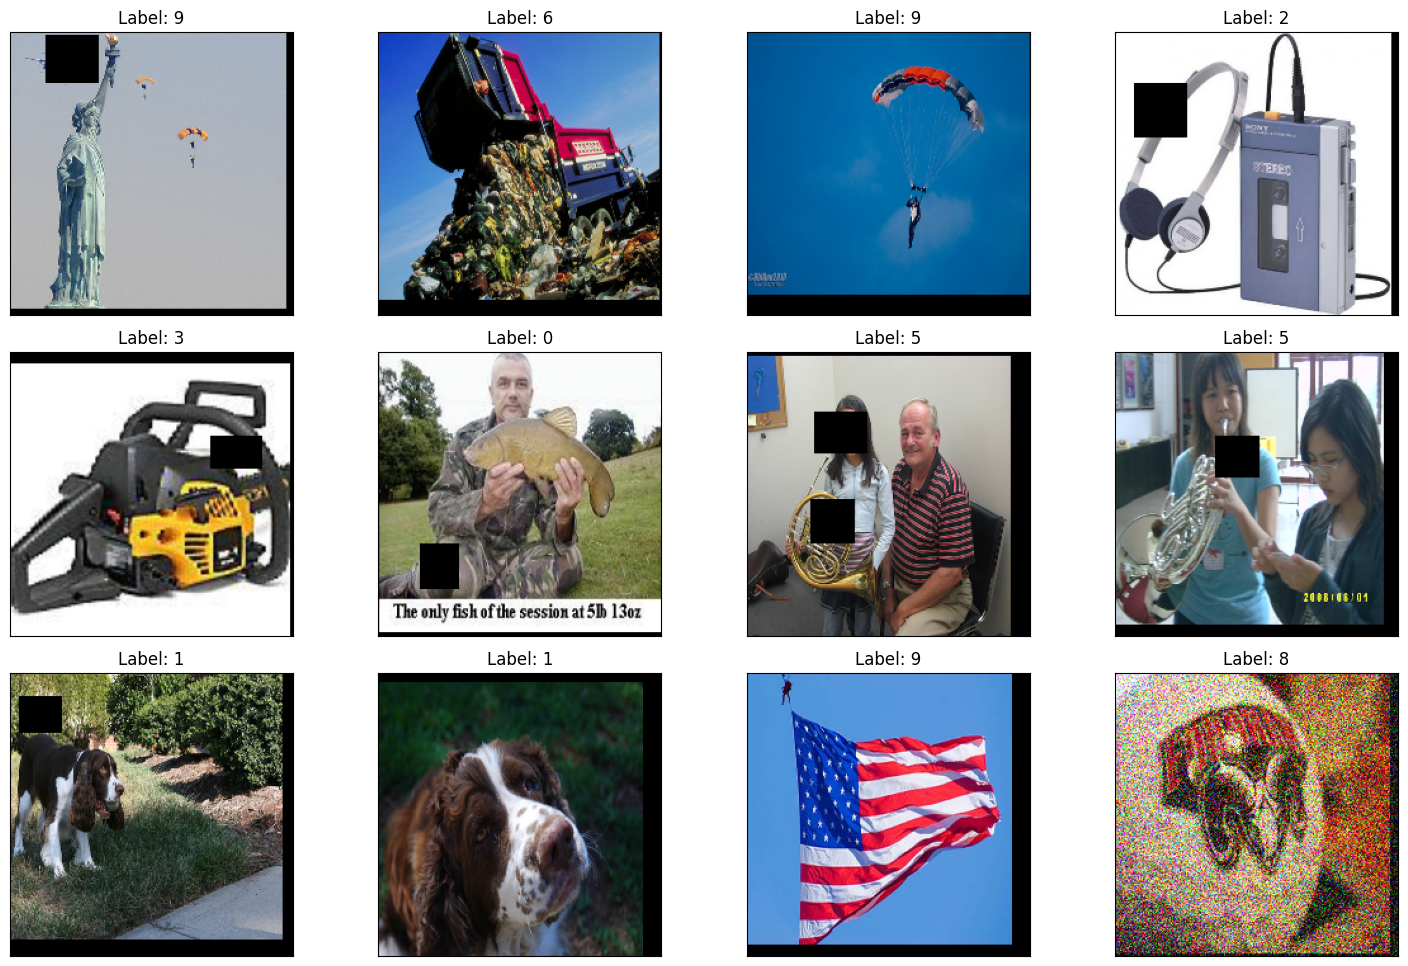

In [ ]:
# Load dataset
print("Loading dataset...")
train_loader, test_loader = get_data_loaders(DATASET_NAME)

# Visualize some samples
print("\nVisualizing sample images...")
visualize_samples(train_loader, num_samples=12)


In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Model Creation

Create the ResNet50 model and display its architecture.


In [ ]:
# Create model
print(f"Creating {Config.MODEL_NAME} model...")
model = get_model(
    model_name=Config.MODEL_NAME,
    dataset_name=DATASET_NAME,
    pretrained=USE_PRETRAINED
)

# Move model to device
model = model.to(device)

# Print model info
print(f"Model parameters: {count_parameters(model):,}")

# Get model summary
dataset_config = Config.get_dataset_config()
input_size = (3, dataset_config["image_size"], dataset_config["image_size"])
print(f"\nModel summary (input size: {input_size}):")
get_model_summary(model, input_size=input_size)


Creating resnet50 model...
Model parameters: 23,528,522

Model summary (input size: (3, 224, 224)):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
   

## Training

Train the model using our modular training utilities.


In [ ]:
# # Train model
# stage_config = Config.STAGES[DATASET_NAME]
# print(stage_config)
# NUM_EPOCHS = stage_config["epochs"]
# BATCH_SIZE = stage_config["batch_size"]
# LEARNING_RATE = stage_config["lr"]
# WEIGHT_DECAY = stage_config["weight_decay"]

# print(f"Starting training for {NUM_EPOCHS} epochs...")
# print(f"Batch size: {BATCH_SIZE}")
# print(f"Learning rate: {LEARNING_RATE}")
# print(f"Weight decay: {WEIGHT_DECAY}")

# metrics_tracker = train_model(model, train_loader, test_loader, device, Config)


{'dataset': 'imagenette', 'classes': 10, 'image_size': 224, 'epochs': 20, 'batch_size': 256, 'lr': 0.001, 'optimizer': 'adamw', 'scheduler': 'cosine', 'weight_decay': 0.0001, 'label_smoothing': 0.1, 'description': 'Quick warmup and architecture validation', 'enabled': True, 'priority': 1}
Starting training for 20 epochs...
Batch size: 256
Learning rate: 0.001
Weight decay: 0.0001

Epoch 1/20


Epoch 1 - Loss=2.2816 - Accuracy=27.03%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test set: Average loss: 2.2926, Top-1 Accuracy: 1024/3925 (26.09%), Top-5 Accuracy: 2778/3925 (70.78%)
New best model saved with test loss: 2.2926
Current learning rate: 0.000995

Epoch 2/20


Epoch 2 - Loss=1.9062 - Accuracy=38.91%: 100%|██████████| 37/37 [00:49<00:00,  1.34s/it]


Test set: Average loss: 2.0043, Top-1 Accuracy: 1391/3925 (35.44%), Top-5 Accuracy: 3239/3925 (82.52%)
New best model saved with test loss: 2.0043
Current learning rate: 0.000996

Epoch 3/20


Epoch 3 - Loss=1.7557 - Accuracy=46.40%: 100%|██████████| 37/37 [00:49<00:00,  1.34s/it]


Test set: Average loss: 1.9440, Top-1 Accuracy: 1562/3925 (39.80%), Top-5 Accuracy: 3349/3925 (85.32%)
New best model saved with test loss: 1.9440
Current learning rate: 0.000996

Epoch 4/20


Epoch 4 - Loss=1.5819 - Accuracy=55.13%:  86%|████████▋ | 32/37 [00:44<00:06,  1.40s/it]


KeyboardInterrupt: 

## Results Visualization

Plot the training metrics and evaluate the final model.


In [ ]:
# # Plot training metrics
# print("Plotting training metrics...")
# metrics_tracker.plot_metrics(save_path=f"{Config.SAVE_MODEL_PATH}/training_metrics.png")

# # Final evaluation
# print("\nFinal evaluation...")
# test_loss, test_acc, test_top5_acc = evaluate_model(model, test_loader, device)

# print(f"\nTraining completed!")
# print(f"Final Test Accuracy: {test_acc:.2f}%")
# print(f"Final Top-5 Accuracy: {test_top5_acc:.2f}%")


## Model Saving

Save the trained model to local storage and Google Drive.


In [ ]:
# # Save final model
# final_model_path = f"{Config.SAVE_MODEL_PATH}/final_model.pth"
# save_model(model, final_model_path, epoch=NUM_EPOCHS, loss=test_loss)

# # Save to Google Drive if mounted
# if Config.MOUNT_DRIVE:
#     drive_model_path = f"{Config.DRIVE_MODEL_PATH}/final_model.pth"
#     save_model(model, drive_model_path, epoch=NUM_EPOCHS, loss=test_loss)
#     print(f"Model also saved to Google Drive: {drive_model_path}")

# print("Model saving completed!")


## Progressive Transfer Learning (Multi-Stage Training)

Run multiple stages in sequence with automatic weight transfer from each stage to the next.


In [ ]:
"""
PROGRESSIVE TRANSFER LEARNING - RUN SELECTED STAGES
===================================================
Train multiple stages in sequence with automatic weight transfer.
"""

import json
from datetime import datetime

# ⚙️ CONFIGURATION - Choose which stages to run
# ================================================
STAGES_TO_RUN = ["imagenette", "tiny_imagenet"]  # Modify this list
# Options: "imagenette", "tiny_imagenet", "imagenet_mini", "imagenet"
# Order matters! Stages run in sequence with weight transfer

USE_PRETRAINED_FOR_FIRST_STAGE = False  # Start with ImageNet pretrained weights?
SAVE_RESULTS_AT_EACH_STAGE = True  # Save models and metrics at each stage?

# Results storage
all_stage_results = {}
pretrained_weights_path = None

# Verify save path exists (create if needed)
print("🚀 Progressive Transfer Learning Training")
print(f"Stages to run: {STAGES_TO_RUN}")
print(f"Start with pretrained: {USE_PRETRAINED_FOR_FIRST_STAGE}")
print(f"Save at each stage: {SAVE_RESULTS_AT_EACH_STAGE}")
print("="*80)

# Check if save path exists
save_path = Config.SAVE_MODEL_PATH
if not os.path.exists(save_path):
    print(f"\n⚠️ Save path doesn't exist: {save_path}")
    print(f"Creating directory...")
    os.makedirs(save_path, exist_ok=True)
    print(f"✅ Created: {save_path}")
else:
    print(f"\n📁 Models will be saved to: {save_path}")
    print(f"   (Directory exists)")

# Verify Google Drive is mounted (if using /gdrive)
if save_path.startswith('/gdrive'):
    gdrive_root = '/gdrive'
    if not os.path.exists(gdrive_root):
        print(f"\n❌ ERROR: Google Drive not mounted!")
        print(f"Please run the 'Mount Google Drive' cell (Cell 11) first.")
        print(f"After mounting, Google Drive will be available at: /gdrive")
    else:
        print(f"✅ Google Drive is mounted at: {gdrive_root}")

print("="*80)

for i, stage_name in enumerate(STAGES_TO_RUN, 1):
    print(f"\n{'='*80}")
    print(f"STAGE {i}/{len(STAGES_TO_RUN)}: {stage_name.upper()}")
    print(f"{'='*80}")

    # Update configuration for this stage
    Config.update_for_dataset(stage_name)

    # Get stage configuration
    stage_config = Config.STAGES[stage_name]
    print(f"Classes: {stage_config['classes']}")
    print(f"Image size: {stage_config['image_size']}")
    print(f"Epochs: {stage_config['epochs']}")
    print(f"Batch size: {stage_config['batch_size']}")
    print(f"LR: {stage_config['lr']}")
    print(f"Previous weights: {pretrained_weights_path or 'None (fresh start)'}")

    # Load dataset
    print(f"\n📦 Loading {stage_name} dataset...")
    train_loader, test_loader = get_data_loaders(stage_name)

    # Create model
    print(f"\n🧠 Creating model for {stage_name}...")
    use_pretrained = USE_PRETRAINED_FOR_FIRST_STAGE if (i == 1 and not pretrained_weights_path) else False
    model = get_model(
        model_name=Config.MODEL_NAME,
        dataset_name=stage_name,
        pretrained=use_pretrained
    )
    model = model.to(device)
    print(f"Model created: {count_parameters(model):,} parameters")

    # Determine next stage name for weight saving
    next_stage = STAGES_TO_RUN[i] if i < len(STAGES_TO_RUN) else None

    # Train with transfer learning
    print(f"\n🏋️ Training {stage_name}...")
    metrics_tracker, final_weights = train_model_with_transfer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        config=Config,
        pretrained_weights_path=pretrained_weights_path,
        next_stage_name=next_stage
    )

    # Save results if requested
    if SAVE_RESULTS_AT_EACH_STAGE:
        stage_save_dir = f"{Config.SAVE_MODEL_PATH}/{stage_name}_stage_{i}"
        os.makedirs(stage_save_dir, exist_ok=True)

        # Save final model
        final_model_path = f"{stage_save_dir}/final_model.pth"
        torch.save(model.state_dict(), final_model_path)
        print(f"✅ Saved model: {final_model_path}")

        # Save metrics
        metrics_data = {
            "stage": stage_name,
            "stage_number": i,
            "final_train_loss": metrics_tracker.train_losses[-1] if metrics_tracker.train_losses else None,
            "final_train_acc": metrics_tracker.train_acc[-1] if metrics_tracker.train_acc else None,
            "final_test_loss": metrics_tracker.test_losses[-1] if metrics_tracker.test_losses else None,
            "final_test_acc": metrics_tracker.test_acc[-1] if metrics_tracker.test_acc else None,
            "config": stage_config
        }

        metrics_path = f"{stage_save_dir}/metrics.json"
        with open(metrics_path, 'w') as f:
            json.dump(metrics_data, f, indent=2)
        print(f"✅ Saved metrics: {metrics_path}")

        # Save metrics plot (graph with training curves)
        plot_path = f"{stage_save_dir}/training_metrics.png"
        metrics_tracker.plot_metrics(save_path=plot_path)
        print(f"✅ Saved training graphs: {plot_path}")

        all_stage_results[stage_name] = {
            "metrics": metrics_data,
            "model_path": final_model_path,
            "plot_path": plot_path
        }

        # Set weights path for next stage
    if next_stage:
        pretrained_weights_path = f"{Config.SAVE_MODEL_PATH}/weights_for_{next_stage}.pth"

    # Free GPU memory before moving to next stage
    if torch.cuda.is_available():
        del model  # Delete model to free memory
        del metrics_tracker  # Delete metrics tracker
        torch.cuda.empty_cache()  # Clear CUDA cache
        print("🧹 GPU memory cleared for next stage")

    print(f"\n✅ Stage {i} completed!")
    print("-"*80)

# Final summary
print("\n" + "="*80)
print("🎉 ALL STAGES COMPLETE!")
print("="*80)
if SAVE_RESULTS_AT_EACH_STAGE:
    print("\n📊 Results Summary:")
    print(f"{'Stage':<20} {'Test Accuracy':<15} {'Model Path':<60}")
    print("-"*95)
    for stage_name, result in all_stage_results.items():
        final_test_acc = result['metrics'].get('final_test_acc', 'N/A')
        model_path = result.get('model_path', 'N/A')
        if isinstance(final_test_acc, (int, float)):
            print(f"{stage_name:<20} {final_test_acc:<15.2f} {model_path}")
        else:
            print(f"{stage_name:<20} {str(final_test_acc):<15} {model_path}")

    print(f"\n{'='*80}")
    print(f"📁 Base Save Directory: {Config.SAVE_MODEL_PATH}")
    if Config.SAVE_MODEL_PATH.startswith('/gdrive'):
        print(f"📂 Location: Google Drive (My Drive/models)")
    print(f"\n📦 For each stage, you'll find:")
    print(f"  • final_model.pth - Trained model weights")
    print(f"  • metrics.json - Training metrics")
    print(f"  • training_metrics.png - Training curves graph")

    # Verify files were actually saved
    print(f"\n{'='*80}")
    print("🔍 Verifying saved files:")
    verify_saved_files(Config.SAVE_MODEL_PATH)


🚀 Progressive Transfer Learning Training
Stages to run: ['imagenette', 'tiny_imagenet']
Start with pretrained: False
Save at each stage: True

📁 Models will be saved to: /gdrive/My Drive/models
   (Directory exists)
✅ Google Drive is mounted at: /gdrive

STAGE 1/2: IMAGENETTE
Configuration updated for imagenette
Image size: 224
Number of classes: 10
Batch size: 256
Epochs: 20
Learning rate: 0.001
Classes: 10
Image size: 224
Epochs: 20
Batch size: 256
LR: 0.001
Previous weights: None (fresh start)

📦 Loading imagenette dataset...
Dataset: imagenette
Train samples: 9469
Test samples: 3925
Batch size: 256
Number of classes: 10

🧠 Creating model for imagenette...
Model created: 23,528,522 parameters
Model output size: 10

🏋️ Training imagenette...

Epoch 1/20


Epoch 1 - Loss=2.2803 - Accuracy=29.50%: 100%|██████████| 37/37 [00:52<00:00,  1.41s/it]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test set: Average loss: 12.7639, Top-1 Accuracy: 1230/3925 (31.34%), Top-5 Accuracy: 2874/3925 (73.22%)
New best model saved with test loss: 12.7639
Current learning rate: 0.000848

Epoch 2/20


Epoch 2 - Loss=1.7635 - Accuracy=44.99%: 100%|██████████| 37/37 [00:50<00:00,  1.36s/it]


Test set: Average loss: 1.6128, Top-1 Accuracy: 2093/3925 (53.32%), Top-5 Accuracy: 3570/3925 (90.96%)
New best model saved with test loss: 1.6128
Current learning rate: 0.000997

Epoch 3/20


Epoch 3 - Loss=1.6336 - Accuracy=52.13%: 100%|██████████| 37/37 [00:51<00:00,  1.39s/it]


Test set: Average loss: 1.6255, Top-1 Accuracy: 2122/3925 (54.06%), Top-5 Accuracy: 3589/3925 (91.44%)
Current learning rate: 0.000997

Epoch 4/20


Epoch 4 - Loss=1.4772 - Accuracy=58.81%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.3991, Top-1 Accuracy: 2476/3925 (63.08%), Top-5 Accuracy: 3699/3925 (94.24%)
New best model saved with test loss: 1.3991
Current learning rate: 0.000998

Epoch 5/20


Epoch 5 - Loss=1.3531 - Accuracy=64.46%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.4820, Top-1 Accuracy: 2371/3925 (60.41%), Top-5 Accuracy: 3685/3925 (93.89%)
Current learning rate: 0.000998

Epoch 6/20


Epoch 6 - Loss=1.2868 - Accuracy=67.42%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.5075, Top-1 Accuracy: 2375/3925 (60.51%), Top-5 Accuracy: 3674/3925 (93.61%)
Current learning rate: 0.000998

Epoch 7/20


Epoch 7 - Loss=1.2261 - Accuracy=70.27%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.2071, Top-1 Accuracy: 2807/3925 (71.52%), Top-5 Accuracy: 3780/3925 (96.31%)
New best model saved with test loss: 1.2071
Current learning rate: 0.000999

Epoch 8/20


Epoch 8 - Loss=1.1655 - Accuracy=72.59%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.2259, Top-1 Accuracy: 2761/3925 (70.34%), Top-5 Accuracy: 3771/3925 (96.08%)
Current learning rate: 0.000999

Epoch 9/20


Epoch 9 - Loss=1.1203 - Accuracy=75.14%: 100%|██████████| 37/37 [00:50<00:00,  1.38s/it]


Test set: Average loss: 1.2033, Top-1 Accuracy: 2824/3925 (71.95%), Top-5 Accuracy: 3775/3925 (96.18%)
New best model saved with test loss: 1.2033
Current learning rate: 0.000999

Epoch 10/20


Epoch 10 - Loss=1.0965 - Accuracy=75.91%: 100%|██████████| 37/37 [00:50<00:00,  1.38s/it]


Test set: Average loss: 1.3326, Top-1 Accuracy: 2730/3925 (69.55%), Top-5 Accuracy: 3778/3925 (96.25%)
Current learning rate: 0.000998

Epoch 11/20


Epoch 11 - Loss=1.0977 - Accuracy=76.12%: 100%|██████████| 37/37 [00:50<00:00,  1.38s/it]


Test set: Average loss: 1.6960, Top-1 Accuracy: 2737/3925 (69.73%), Top-5 Accuracy: 3757/3925 (95.72%)
Current learning rate: 0.000997

Epoch 12/20


Epoch 12 - Loss=1.0668 - Accuracy=76.69%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.1845, Top-1 Accuracy: 2819/3925 (71.82%), Top-5 Accuracy: 3778/3925 (96.25%)
New best model saved with test loss: 1.1845
Current learning rate: 0.000999

Epoch 13/20


Epoch 13 - Loss=1.0312 - Accuracy=79.16%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.3265, Top-1 Accuracy: 2723/3925 (69.38%), Top-5 Accuracy: 3780/3925 (96.31%)
Current learning rate: 0.000998

Epoch 14/20


Epoch 14 - Loss=1.0996 - Accuracy=76.81%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 3.2234, Top-1 Accuracy: 2468/3925 (62.88%), Top-5 Accuracy: 3673/3925 (93.58%)
Current learning rate: 0.000990

Epoch 15/20


Epoch 15 - Loss=1.0290 - Accuracy=78.90%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.1128, Top-1 Accuracy: 3014/3925 (76.79%), Top-5 Accuracy: 3806/3925 (96.97%)
New best model saved with test loss: 1.1128
Current learning rate: 0.000999

Epoch 16/20


Epoch 16 - Loss=0.9721 - Accuracy=81.34%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.1945, Top-1 Accuracy: 2871/3925 (73.15%), Top-5 Accuracy: 3794/3925 (96.66%)
Current learning rate: 0.000999

Epoch 17/20


Epoch 17 - Loss=0.9572 - Accuracy=82.15%: 100%|██████████| 37/37 [00:50<00:00,  1.37s/it]


Test set: Average loss: 1.2682, Top-1 Accuracy: 2754/3925 (70.17%), Top-5 Accuracy: 3739/3925 (95.26%)
Current learning rate: 0.000998

Epoch 18/20


Epoch 18 - Loss=0.9685 - Accuracy=81.72%:  38%|███▊      | 14/37 [00:20<00:30,  1.34s/it]